## Analyzing a movie

We are going to apply the different capabilities build in order to predict actors in a movie

### Importing libraries

In [ ]:
import sys
import os
import json
import pandas as pd
import numpy as np
!pip install pandasql
from pandasql import sqldf
import matplotlib.pyplot as plt
from time import time, strftime, localtime, gmtime, sleep
from random import randrange
import random
sys.path.append('/opt/workspace/src/python_scripts/')
from ops_face_recognition import train_recognizer,get_probabilities_for_folder
from ops_files_operations import read_pickle_file, read_json_file, get_element_from_metadata, create_pickle_file
from ops_face_detection import process_video, get_video_embeddings,get_frame_from_video, get_embeddings_from_image
from ops_results_interpretation import get_frames_df, get_actors_probs_query, get_predicted_timeline, get_summarized_timeline
from ops_logger import Logger
from IPython.display import clear_output
from IPython import display

### Processing movie

#### Obtaining movie embeddings

In [ ]:
movie_path = './datasets/videos/inception.mkv'
output_path = './models/embeddings/processed_videos'
get_video_embeddings(
    video_path = movie_path,
    results_path = output_path,
    partitions=32, 
    desired_fps=4
)

#### Defining paths

In [ ]:
movie_embeddings_path = './models/embeddings/processed_videos/inception'
processed_videos_metadata_path = './models/embeddings/processed_videos/inception/processed_videos_metadata.json'
results_folder = './models/results'
results_metadata_path = './models/results/probabilities_metadata.json'
recognizer_metadata_path = './models/recognizers/recognizer_metadata.json'
recognizer_path = './models/recognizers'

#### Getting processed_video_id and recognizer_id

In [ ]:
processed_video_id = get_element_from_metadata(
    metadata_file_path=processed_videos_metadata_path,
    latest=True
)["processed_video_id"]

recognizer_id = get_element_from_metadata(
    metadata_file_path=recognizer_metadata_path,
    latest=True
)["recognizer_id"]

#### Predicting results for movie

In [ ]:
folder_probabilities, folder_probabilities_metadata = get_probabilities_for_folder(
    folder_path = movie_embeddings_path,
    recognizer_folder = recognizer_path,
    save_to_pickle = True,
    output_folder = results_folder,
    processed_video_id = processed_video_id,
    recognizer_id = recognizer_id
)

#### Getting results_id and other metadata files

In [ ]:
results_metadata = get_element_from_metadata(
    metadata_file_path=results_metadata_path,
    #key = 'results_id',
    #value = results_id,
    latest=True
)

processed_videos_metadata = get_element_from_metadata(
    metadata_file_path=processed_videos_metadata_path,
    key = 'processed_video_id',
    value = results_metadata['processed_video_id']
)
recognizer_metadata = get_element_from_metadata(
    metadata_file_path=recognizer_metadata_path,
    key = 'recognizer_id',
    value = results_metadata['recognizer_id']
)

pickle_path = results_metadata['pickle_path']
results_id = results_metadata['results_id']
#results = read_pickle_file(pickle_path)

### Understanding results for all actors in a video

In [ ]:
summarized_timeline = get_summarized_timeline(
    results_id=results_id,
    processed_videos_metadata_path=processed_videos_metadata_path
)


In [ ]:
create_pickle_file(summarized_timeline,'./models/timelines/summarized_timeline.pickle')

In [14]:
length_threshold = 24
sum_pred_value_threshold = 8
max_pred_value_threshold = 0.8

final_timeline = sqldf("""
    select *
    from full_timeline 
    where length >= {0} or sum_pred_value >= {1} or max_pred_value >= {2}
""".format(length_threshold,sum_pred_value_threshold,max_pred_value_threshold))

In [55]:
create_pickle_file(timeline,'./models/timelines/inception_final_timeline_model1.pickle')

In [ ]:
sqldf("""

    with flags as (
    
        select
            *,
            
            true as is_base_model,
            
            case
                when length >= 12 or sum_pred_value >= 4 or max_pred_value >= 0.6 then true
                else false
            end as is_model_1,
            
            case
                when length >= 24 or sum_pred_value >= 8 or max_pred_value >= 0.8 then true
                else false
            end as is_model_2
            

        from full_timeline

    )
    
    select
        is_model_2,
        count(*)
    from flags
    group by 1
    
    
    
""")

#### Tester

In [44]:
full_timeline = read_pickle_file('./models/timelines/summarized_timeline_flagged.pickle')
sqldf("""
    select *
    from full_timeline

""")

,id,actor,frame_number_from,timestamp_from,frame_number_to,timestamp_to,length,max_pred_value,sum_pred_value,user_validation
0,1,4935_pete_postlethwaite,1452,00:01:00.560,1476,00:01:01.561,7,0.287891,1.570916,None
1,2,3899_ken_watanabe,1464,00:01:01.61,1476,00:01:01.561,4,0.232450,0.904958,None
2,3,3899_ken_watanabe,1500,00:01:02.562,1512,00:01:03.63,4,0.222714,0.811691,None
3,4,4935_pete_postlethwaite,1512,00:01:03.63,1524,00:01:03.563,4,0.424892,1.652843,None
4,5,3895_michael_caine,1524,00:01:03.563,1536,00:01:04.64,4,0.185739,0.739360,None
...,...,...,...,...,...,...,...,...,...,...
2584,2585,3895_michael_caine,201912,02:20:21.413,201924,02:20:21.913,4,0.340590,1.359570,None
2585,2586,3899_ken_watanabe,201912,02:20:21.413,201936,02:20:22.414,7,0.270634,1.663059,None
2586,2587,6193_leonardo_dicaprio,201936,02:20:22.414,201960,02:20:23.415,7,0.268434,1.752423,None
2587,2588,2524_tom_hardy,201948,02:20:22.914,201960,02:20:23.415,4,0.319322,1.266722,None


In [80]:
num_of_test = 20
images_per_zone = 4
scene_path = './datasets/videos/inception.mkv'
full_timeline = read_pickle_file('./models/timelines/summarized_timeline_flagged.pickle')
model = 2

if model == 1:
    length_threshold = 12
    sum_pred_value_threshold = 4
    max_pred_value_threshold = 0.6
if model == 2:
    length_threshold = 24
    sum_pred_value_threshold = 8
    max_pred_value_threshold = 0.8

timeline = sqldf(f"""
    select
        *
    from full_timeline
    where
        (length >= {length_threshold} or sum_pred_value >= {sum_pred_value_threshold} or max_pred_value >= {max_pred_value_threshold})
        and user_validation is null

""")

results = []
available_records = int(timeline.shape[0])
if num_of_test <= available_records:
    sample_num = num_of_test
else:
    sample_num = available_records

prediction_nums = random.sample(range(available_records), sample_num)

for its, num in enumerate(prediction_nums):
    prediction = timeline.loc[[int(num)]]
    first_frame_num = int(prediction["frame_number_from"])
    last_frame_num = int(prediction["frame_number_to"])
    step = round((last_frame_num - first_frame_num)/images_per_zone)
    
    frames=[]
    counter = first_frame_num
    
    while counter < last_frame_num:
        frames.append(get_frame_from_video(video_path = scene_path,frame_number = counter))
        counter = counter + step
    
    f = plt.figure(figsize=[20,20])
    
    for it_num,frame in enumerate(frames):
        f.add_subplot(1,len(frames), it_num+1)        
        plt.imshow(frame[:,:,::-1])
        plt.title(f"Image {its+1}/{sample_num}, frame {first_frame_num + (step*(it_num))} ")
        plt.axis('off');
        
    plt.show()
    
    clear_output(wait=True)
    user_guess = input(f"Is {prediction['actor'].values[0]} in any this picture? (1 = Yes, 0 = No)")
    results.append(user_guess)
    full_timeline.loc[full_timeline["id"] == int(prediction["id"]),"user_validation"] = user_guess
    
hits = 0
for result in results:
    if int(result) == 1:
        hits = hits + 1

clear_output(wait=True)
create_pickle_file(full_timeline,'./models/timelines/summarized_timeline_flagged.pickle')
print(f'Total hits: {hits}. Accuracy: {(hits/num_of_test)*100}%')

Total hits: 9. Accuracy: 45.0%


In [81]:
sqldf("""
    select *
    from full_timeline
    where user_validation is not null

""")

,id,actor,frame_number_from,timestamp_from,frame_number_to,timestamp_to,length,max_pred_value,sum_pred_value,user_validation
0,27,6193_leonardo_dicaprio,4440,00:03:05.185,4560,00:03:10.190,31,0.469165,9.507638,1
1,34,2524_tom_hardy,4776,00:03:19.199,4848,00:03:22.202,19,0.559903,8.085898,0
2,37,2524_tom_hardy,5052,00:03:30.710,5232,00:03:38.218,46,0.682265,22.641382,0
3,38,6193_leonardo_dicaprio,5052,00:03:30.710,5328,00:03:42.222,70,0.545850,23.034437,1
4,72,4935_pete_postlethwaite,8544,00:05:56.356,8628,00:05:59.859,22,0.600716,8.188691,0
...,...,...,...,...,...,...,...,...,...,...
87,2470,3899_ken_watanabe,196176,02:16:22.174,196512,02:16:36.188,85,0.434803,25.075570,0
88,2485,13022_tom_berenger,197232,02:17:06.218,197328,02:17:10.222,25,0.333301,6.025152,0
89,2501,3895_michael_caine,197796,02:17:29.742,197916,02:17:34.746,31,0.315904,7.318656,0
90,2515,4935_pete_postlethwaite,198216,02:17:47.259,198312,02:17:51.263,25,0.406926,8.579551,0


In [64]:
sqldf("""
    select
        frame_number_from,
        frame_number_to,
        count(*)
    from full_timeline
    --where user_validation is not null
    group by 1,2
    having count(*) > 1
    order by count(*) desc

""")

,frame_number_from,frame_number_to,count(*)
0,1668,1680,2
1,1692,1704,2
2,3732,3744,2
3,5460,5472,2
4,5928,5940,2
...,...,...,...
257,199752,199776,2
258,200136,200148,2
259,201432,201444,2
260,201456,201492,2


In [71]:
sqldf("""
    select * from full_timeline
    where frame_number_from = 5928 and frame_number_to = 5940
    

""")

,id,actor,frame_number_from,timestamp_from,frame_number_to,timestamp_to,length,max_pred_value,sum_pred_value,user_validation
0,45,2524_tom_hardy,5928,00:04:07.247,5940,00:04:07.747,4,0.255089,1.005253,None
1,46,6193_leonardo_dicaprio,5928,00:04:07.247,5940,00:04:07.747,4,0.298922,0.938803,None


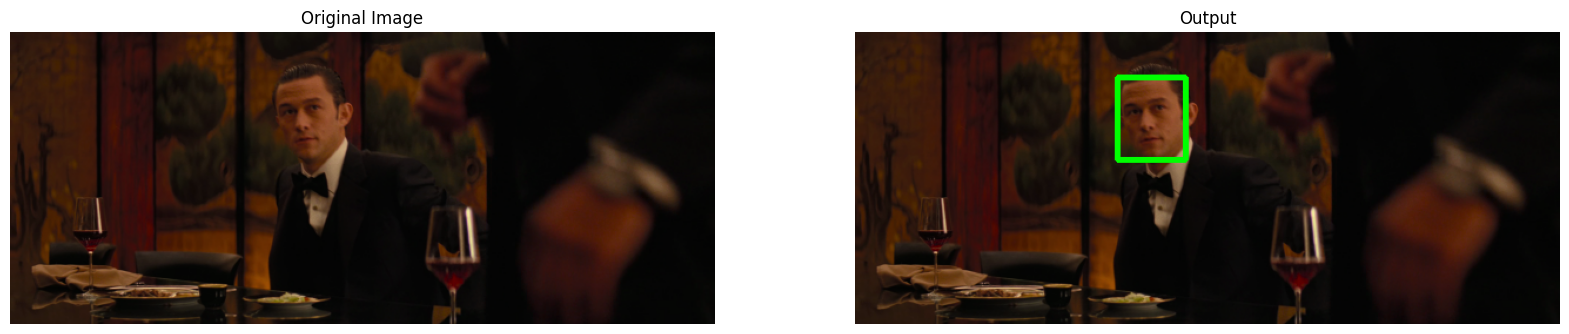

In [72]:
scene_path = './datasets/videos/inception.mkv'
frame = get_frame_from_video(video_path = scene_path,frame_number = 5930)#timestamp = '00:00:12.000')
embs, embs_metadata = get_embeddings_from_image(provided_image=frame, multiple_faces=True, display=True)